In [53]:
#!pip install tensorflow
#!pip install keras
#!pip install gensim


In [292]:
#librerías, no es necesario volverlas a importar

import pandas as pd
import os
import gc
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import multiprocessing
from collections import Counter

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers, Sequential

from gensim.models import Word2Vec

%run ../0_Data/0_DataLoader.ipynb

[nltk_data] Downloading package punkt to /home/celeste/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/celeste/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/celeste/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Datos

In [381]:
x_train_original, train_y = get_train_x_y_original()

x_test_original = get_test_x_original()

x_train_preprocesado = preprocesar_data (x_train_original, clean_text_sentiment_analysis)

x_test_preprocesado = preprocesar_data (x_test_original, clean_text_sentiment_analysis)

In [4]:
x_train_preprocesado.head()

id
1    our deed are the reason of this earthquak may ...
4                 forest fire near la rong sask canada
5    all resid ask to shelter in place are be notif...
6    13000 peopl receiv wildfir evacu order in cali...
7    just got sent this photo from rubi alaska as s...
Name: text, dtype: object

In [8]:
x_test_preprocesado.head()

id
0                       just happen a terribl car crash
2     heard about earthquak is differ citi stay safe...
3     there is a forest fire at spot pond gees are f...
9                        apocalyps light spokan wildfir
11         typhoon soudelor kill 28 in china and taiwan
Name: text, dtype: object

id
1    our deed are the reason of this may allah forg...
4                 forest fire near la rong sask canada
5    all resid ask to shelter in place are be notif...
6         13000 peopl receiv evacu order in california
7    just got sent this photo from rubi as smoke fr...
Name: texto_preprocesado, dtype: object

# 2. Embeddings sin preentrenar

In [122]:
def plot_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(x, acc, 'r', label='Training acc')
    plt.plot(x, loss, 'b', label='Training loss')
    plt.title('Training accuracy vs loss')
    plt.legend()

In [5]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 200 # max number of words in a question to use


In [26]:
def liberar_memoria (var):
    del var
    gc.collect()
    sleep(10)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 300)          15000000  
_________________________________________________________________
flatten_4 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                600010    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 15,600,021
Trainable params: 15,600,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.59 - ETA: 1s - loss: 0.7162 - accuracy: 0.58 - ETA: 2s - loss: 0.7084 - accuracy: 0.54 - ETA: 1s - loss: 0.7030 - accuracy: 0.55 - ETA: 1s - loss: 0.69

Training Accuracy: 0.9953


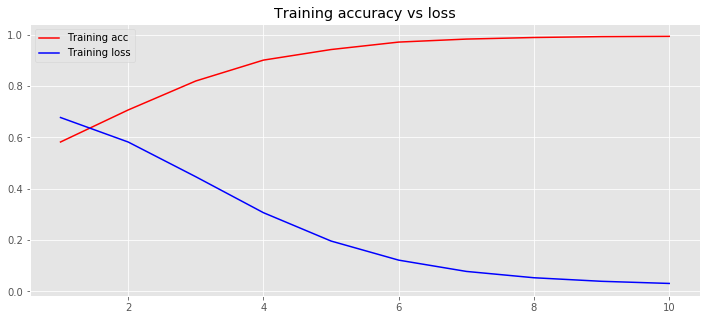

In [41]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train_original))
train_X = tokenizer.texts_to_sequences(x_train_original)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(input_dim=max_features, 
                           output_dim=embed_size, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(train_X, train_y,
                    epochs=10,
                    batch_size=512)


loss, accuracy = model.evaluate(train_X, train_y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
plot_history(history)

In [97]:
liberar_memoria(model)

In [42]:
test_X = tokenizer.texts_to_sequences(x_test_original)

## Pad the sentences 
test_X = pad_sequences(test_X, maxlen=maxlen)


#y_test = model.predict(test_X, batch_size=1024, verbose=1)
#y_test = model.predict_classes(test_X, batch_size=1024, verbose=1)

y_test = (model.predict(test_X, batch_size=1024, verbose=1) > 0.5).astype("int32")

4/4 [==============================] - ETA:  - ETA:  - ETA:  - 0s 37ms/step


In [43]:
pred_y = model.predict_classes(train_X, batch_size=1024, verbose=1)
print("Report: \n{}".format(classification_report(train_y, pred_y)))

8/8 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 52ms/step


Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4342
           1       0.99      1.00      0.99      3271

    accuracy                           1.00      7613
   macro avg       1.00      1.00      1.00      7613
weighted avg       1.00      1.00      1.00      7613



In [45]:
pred_y

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [46]:
submission = pd.read_csv(os.path.join('..','0_Data','dataset','sample_submission.csv'))
submission['target'] = y_test
submission.to_csv("submission2.csv", index=False)

In [47]:
len(y_test)

3263

In [14]:
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,1


# 3. Embedding Word2Vec preentrenados

In [124]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [1]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 200 # max number of words in a tweet to use

## obtengo el vocabulario
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train_original)+ list(x_test_original))

## indice del vocabulario
word_index = tokenizer.word_index

## para proecesarlo necesito una lista de palabras por  tweet
tweets_list_train = [text_to_word_sequence(sentence) for sentence in x_train_original]
tweets_list_test = [text_to_word_sequence(sentence) for sentence in x_test_original]
tweets_all = tweets_list_train + tweets_list_test

## creo el modelo de word2vec
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=embed_size,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

## se genera el vocabulario

t = time()

w2v_model.build_vocab(tweets_all, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

# se entrena el modelo word2vec

t = time()

w2v_model.train(tweets_all, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

word_vectors = w2v_model.wv

print("Number of word vectors: {}".format(len(word_vectors.vocab)))

MAX_NB_WORDS = len(word_vectors.vocab)

wv_matrix = (np.random.rand(MAX_NB_WORDS, embed_size) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass    
    

model2 = Sequential()
model2.add(layers.Embedding(input_dim=max_features, 
                           output_dim=embed_size, 
                           input_length=maxlen))
model2.add(layers.Flatten())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.summary()

train_X = tokenizer.texts_to_sequences(x_train_original)

# pad
train_X = pad_sequences(train_X, maxlen=maxlen, 
                     padding="pre", truncating="post")

print('Shape of data tensor:', train_X.shape)

history2 = model2.fit(train_X, train_y,
                    epochs=10,
                    batch_size=512)


loss, accuracy = model2.evaluate(train_X, train_y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
plot_history(history2)

NameError: name 'Tokenizer' is not defined

In [324]:
train_X = tokenizer.texts_to_sequences(x_train_original)

# pad
train_X = pad_sequences(train_X, maxlen=maxlen, 
                     padding="pre", truncating="post")

pred_y = model2.predict_classes(train_X, batch_size=1024, verbose=1)
print("Report: \n{}".format(classification_report(train_y, pred_y)))

8/8 [==============================] - 0s 51ms/step
Report: 
              precision    recall  f1-score   support

           0       0.59      0.81      0.68      4342
           1       0.49      0.25      0.33      3271

    accuracy                           0.56      7613
   macro avg       0.54      0.53      0.50      7613
weighted avg       0.54      0.56      0.53      7613



In [131]:
test_X = tokenizer.texts_to_sequences(x_test_original)

## Pad the sentences 
test_X = pad_sequences(test_X, maxlen=maxlen)

y_test = (model2.predict(test_X, batch_size=1024, verbose=1) > 0.5).astype("int32")

4/4 [==============================] - 0s 35ms/step


In [132]:
submission = pd.read_csv(os.path.join('..','0_Data','dataset','sample_submission.csv'))
submission['target'] = y_test
submission.to_csv("submission3.csv", index=False)

In [322]:
pd.set_option('display.max_colwidth', -1)

df = pd.DataFrame(x_train_original)
df['target']= train_y
df['clean'] = tweets_list_train
df.loc[(pred[0] != train_y.values).values,['text','target']]

/home/celeste/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,text,target
id,,
365,@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu,1
898,To fight bioterrorism sir.,0
916,To fight bioterrorism sir.,0
1723,Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...,1
1752,I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????,0
1760,like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,1
1899,My hand is burning,1
2929,@bluebirddenver #FETTILOOTCH IS #SLANGLUCCI OPPRESSIONS GREATEST DANGER COMING SOON THE ALBUM \nhttps://t.co/moLL5vd8yD,1
3414,@TemecaFreeman GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings,1


/home/celeste/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,text,target
id,,
365,@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu,1
898,To fight bioterrorism sir.,0
916,To fight bioterrorism sir.,0
1723,Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...,1
1752,I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????,0
1760,like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,1
1899,My hand is burning,1
2929,@bluebirddenver #FETTILOOTCH IS #SLANGLUCCI OPPRESSIONS GREATEST DANGER COMING SOON THE ALBUM \nhttps://t.co/moLL5vd8yD,1
3414,@TemecaFreeman GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings,1


In [186]:
texto='@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu 	'

In [184]:
empty = ' '*(len(string.punctuation))

'                                '

In [193]:
x_train_preprocesado = preprocesar_data (x_train_original, clean_text_simple)

x_test_preprocesado = preprocesar_data (x_test_original, clean_text_simple)

In [194]:
x_train_preprocesado

id
1        our deeds are the reason of this  earthquake may allah forgive us all                                                                    
4        forest fire near la ronge sask  canada                                                                                                   
5        all residents asked to  shelter in place  are being notified by officers  no other evacuation or shelter in place orders are expected    
6        13 000 people receive  wildfires evacuation orders in california                                                                         
7        just got sent this photo from ruby  alaska as smoke from  wildfires pours into a school                                                  
                                                   ...                                                                                            
10869    two giant cranes holding a bridge collapse into nearby homes                                              

In [237]:
liberar_memoria(w2v_model)
liberar_memoria(model3)

Time to build vocab: 0.0 mins
Time to train the model: 0.04 mins
Number of word vectors: 1187
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 300)          15000000  
_________________________________________________________________
flatten_9 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                600010    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 15,600,021
Trainable params: 15,600,021
Non-trainable params: 0
_________________________________________________________________
Shape of data tensor: (7613, 200)
Epoch 1/12
15/15 [==============================] - 3s 198ms/step - loss: 0.7604 - accuracy: 0.5093
Epoch 2/12
1

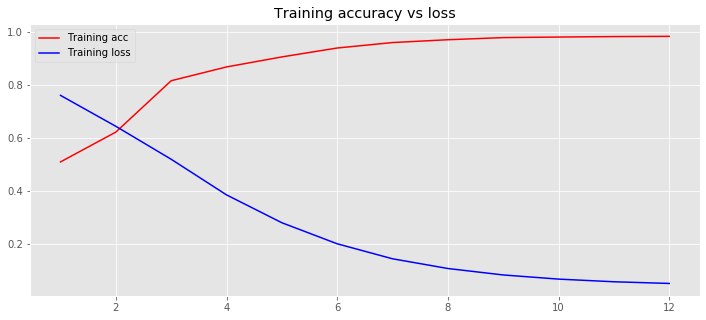

In [238]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 200 # max number of words in a tweet to use

## obtengo el vocabulario
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train_preprocesado)+ list(x_test_preprocesado))

## indice del vocabulario
word_index = tokenizer.word_index

## para proecesarlo necesito una lista de palabras por  tweet
tweets_list_train = [text_to_word_sequence(sentence) for sentence in x_train_preprocesado]
tweets_list_test = [text_to_word_sequence(sentence) for sentence in x_test_preprocesado]
tweets_all = tweets_list_train + tweets_list_test

## creo el modelo de word2vec
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=embed_size,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

## se genera el vocabulario

t = time()

w2v_model.build_vocab(tweets_all, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

# se entrena el modelo word2vec

t = time()

w2v_model.train(tweets_all, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

word_vectors = w2v_model.wv

print("Number of word vectors: {}".format(len(word_vectors.vocab)))

MAX_NB_WORDS = min(max_features, len(word_index))

wv_matrix = (np.random.rand(MAX_NB_WORDS, embed_size) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass    
    

model3 = Sequential()
model3.add(layers.Embedding(input_dim=max_features, 
                           output_dim=embed_size, 
                           input_length=maxlen))
model3.add(layers.Flatten())
model3.add(layers.Dense(10, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model3.summary()

train_X = tokenizer.texts_to_sequences(x_train_preprocesado)

# pad
train_X = pad_sequences(train_X, maxlen=maxlen, 
                     padding="pre", truncating="post")

print('Shape of data tensor:', train_X.shape)

history3 = model3.fit(train_X, train_y,
                    epochs=12,
                    batch_size=512)


loss, accuracy = model3.evaluate(train_X, train_y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
plot_history(history3)

In [239]:
pred_y = model3.predict_classes(train_X, batch_size=1024, verbose=1)
print("Report: \n{}".format(classification_report(train_y, pred_y)))

8/8 [==============================] - 0s 51ms/step
Report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4342
           1       0.99      0.98      0.98      3271

    accuracy                           0.99      7613
   macro avg       0.99      0.98      0.99      7613
weighted avg       0.99      0.99      0.99      7613



In [240]:
test_X = tokenizer.texts_to_sequences(x_test_preprocesado)

## Pad the sentences 
test_X = pad_sequences(test_X, maxlen=maxlen)

y_test = (model3.predict(test_X, batch_size=1024, verbose=1) > 0.5).astype("int32")

4/4 [==============================] - 0s 36ms/step


In [241]:
submission = pd.read_csv(os.path.join('..','0_Data','dataset','sample_submission.csv'))
submission['target'] = y_test
submission.to_csv("submission5.csv", index=False)

In [242]:
pd.set_option('display.max_colwidth', -1)

df = pd.DataFrame(x_train_original)

df['target']= train_y
df['pred'] = pred_y
df['clean'] = tweets_list_train
df.index= range(0,7613)
df.loc[df['pred']!=df['target'],:]


/home/celeste/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,text,target,pred,clean
251,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/sW1sBua3mN via @Change,1,0,"[u, s, national, park, services, tonto, national, forest, stop, the, annihilation, of, the, salt, river, wild, horse, via]"
253,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... http://t.co/KPQk0C4G0M via @Change,1,0,"[u, s, national, park, services, tonto, national, forest, stop, the, annihilation, of, the, salt, river, wild, horse, via]"
257,@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu,1,0,"[we, need, help, horses, will, die, please, retweet, sign, petition, take, a, stand, be, a, voice, for, them, gilbert23]"
269,World Annihilation vs Self Transformation http://t.co/pyehwodWun Aliens Attack to Exterminate Humans http://t.co/8jxqL8Cv8Z,1,0,"[world, annihilation, vs, self, transformation, aliens, attack, to, exterminate, humans]"
271,U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... http://t.co/SB5R7ShcCJ via @Change,1,0,"[u, s, national, park, services, tonto, national, forest, stop, the, annihilation, of, the, salt, river, wild, horse, via]"
...,...,...,...,...
6840,Hollywood Movie About Trapped Miners Released in Chile: 'The 33' Hollywood movie about trapped miners starring... http://t.co/0f8XA4Ih1U,1,0,"[hollywood, movie, about, trapped, miners, released, in, chile, the, 33, hollywood, movie, about, trapped, miners, starring]"
6894,@disneyIrh so traumatised im ???? http://t.co/TATZfK63Ch,1,0,"[so, traumatised, im]"
7056,A look at state actions a year after Ferguson's upheaval http://t.co/GZEkQWzijq,0,1,"[a, look, at, state, actions, a, year, after, ferguson, s, upheaval]"
7068,A look at state actions a year after Ferguson's upheaval http://t.co/TBQsqtmqV4,0,1,"[a, look, at, state, actions, a, year, after, ferguson, s, upheaval]"


In [249]:
for word in df.iloc[7056,3]:
    try:
        embed = word_vectors[word]
        print (word )
    except:
        print ("-----" + word)

a
look
at
state
-----actions
a
year
after
-----ferguson
s
upheaval


In [228]:
len(word_index.keys())

18834

In [232]:
word_vectors.vocab.keys()

dict_keys(['our', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'us', 'all', 'forest', 'fire', 'near', 'la', 'to', 'in', 'place', 'being', 'by', 'no', 'other', 'evacuation', 'or', '13', 'people', 'california', 'just', 'got', 'photo', 'from', 'as', 'smoke', 'into', 'a', 'school', 'update', '20', 'closed', 'both', 'due', 'county', 'flood', 'disaster', 'heavy', 'rain', 'causes', 'flash', 'flooding', 'colorado', 'i', 'am', 'on', 'top', 'and', 'can', 'see', 'there', 'is', 'an', 'emergency', 'now', 'building', 'across', 'street', 'that', 'tornado', 'coming', 'area', 'three', 'died', 'heat', 'wave', 'so', 'far', 'haha', 'south', 'getting', 'wait', 'second', 'live', 'what', 'gonna', 'do', '18', 'days', 'have', 'lost', 'myanmar', 'we', 'damage', 'bus', 'car', 'crash', 'breaking', 'up', 'man', 'love', 'summer', 'my', 'fast', 'london', 'cool', 'day', 'way', 'cannot', 'shit', 'was', 'new', 'york', 'city', 'last', 'week', 'you', 'like', 'end', 'ablaze', 'always', 'try', 'bring', 'rt', 

# 4. Embedding Word2Vec sin preentrenar

In [326]:
%run ../0_Data/0_DataLoader.ipynb

[nltk_data] Downloading package punkt to /home/celeste/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/celeste/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/celeste/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [357]:
liberar_memoria(w2v_model)
liberar_memoria(model4)

In [343]:
x_train_preprocesado = x_train_original

x_test_preprocesado = x_test_original

In [331]:
clean_text_simple("@@@cele 123 abc!aaa")

'   123 abc aaa'

In [344]:
x_train_preprocesado

id
1        Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all                                                                    
4        Forest fire near La Ronge Sask. Canada                                                                                                   
5        All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected    
6        13,000 people receive #wildfires evacuation orders in California                                                                         
7        Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school                                                  
                                                   ...                                                                                            
10869    Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5                       

Time to build vocab: 0.0 mins
Time to train the model: 0.05 mins
Number of word vectors: 1210
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 200, 300)          15000000  
_________________________________________________________________
flatten_24 (Flatten)         (None, 60000)             0         
_________________________________________________________________
dense_48 (Dense)             (None, 10)                600010    
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 11        
Total params: 15,600,021
Trainable params: 15,600,021
Non-trainable params: 0
_________________________________________________________________
Shape of data tensor: (7613, 200)
Epoch 1/10
15/15 [==============================] - 3s 200ms/step - loss: 0.7116 - accuracy: 0.5513
Epoch 2/10


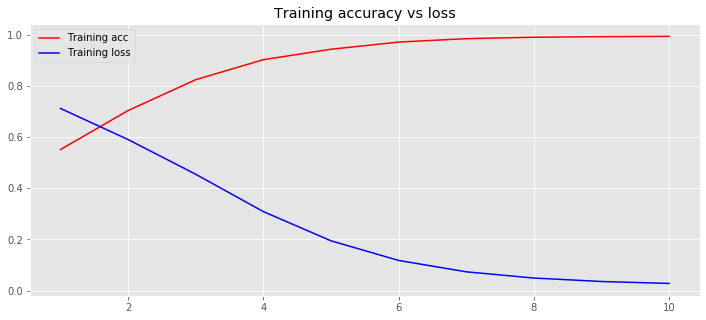

In [358]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 200 # max number of words in a tweet to use

## obtengo el vocabulario
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train_preprocesado)+ list(x_test_preprocesado))

## indice del vocabulario
word_index = tokenizer.word_index

## para proecesarlo necesito una lista de palabras por  tweet
tweets_list_train = [text_to_word_sequence(sentence) for sentence in x_train_preprocesado]
tweets_list_test = [text_to_word_sequence(sentence) for sentence in x_test_preprocesado]
tweets_all = tweets_list_train + tweets_list_test

## creo el modelo de word2vec
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=embed_size,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

## se genera el vocabulario

t = time()

w2v_model.build_vocab(tweets_all, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

# se entrena el modelo word2vec

t = time()

w2v_model.train(tweets_all, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

word_vectors = w2v_model.wv

print("Number of word vectors: {}".format(len(word_vectors.vocab)))

MAX_NB_WORDS = min(max_features, len(word_index))

wv_matrix = (np.random.rand(MAX_NB_WORDS, embed_size) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass    
    

model4 = Sequential()
model4.add(layers.Embedding(input_dim=max_features, 
                           output_dim=embed_size, 
                           input_length=maxlen))
model4.add(layers.Flatten())
model4.add(layers.Dense(10, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model4.summary()

train_X = tokenizer.texts_to_sequences(x_train_preprocesado)

# pad
train_X = pad_sequences(train_X, maxlen=maxlen, 
                     padding="pre", truncating="post")

print('Shape of data tensor:', train_X.shape)

history4 = model4.fit(train_X, train_y,
                    epochs=10,
                    batch_size=512)


loss, accuracy = model4.evaluate(train_X, train_y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
plot_history(history4)



In [359]:
pred_y = model4.predict_classes(train_X, batch_size=1024, verbose=1)
print("Report: \n{}".format(classification_report(train_y, pred_y)))

8/8 [==============================] - 0s 51ms/step
Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4342
           1       1.00      0.99      0.99      3271

    accuracy                           1.00      7613
   macro avg       1.00      1.00      1.00      7613
weighted avg       1.00      1.00      1.00      7613



In [361]:
df = pd.DataFrame(x_train_original)

df['target']= train_y
df['pred'] = pred_y
df['clean'] = tweets_list_train
df.index= range(0,7613)
df.loc[df['pred']!=df['target'],:]

,text,target,pred,clean
165,I had a airplane accident.,1,0,"[i, had, a, airplane, accident]"
624,To fight bioterrorism sir.,0,1,"[to, fight, bioterrorism, sir]"
634,To fight bioterrorism sir.,0,1,"[to, fight, bioterrorism, sir]"
1197,Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...,1,0,"[mmmmmm, i'm, burning, i'm, burning, buildings, i'm, building, oooooohhhh, oooh, ooh]"
1214,I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????,0,1,"[i, pledge, allegiance, to, the, p, o, p, e, and, the, burning, buildings, of, epic, city]"
1315,My hand is burning,1,0,"[my, hand, is, burning]"
1349,like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,0,1,"[like, for, the, music, video, i, want, some, real, action, shit, like, burning, buildings, and, police, chases, not, some, weak, ben, winston, shit]"
2375,@TemecaFreeman GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings,1,0,"[temecafreeman, gm, i, pray, any, attack, of, the, enemy, 2, derail, ur, destiny, is, blocked, by, the, lord, amp, that, he, floods, ur, life, w, heavenly, blessings]"
2832,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,0,1,"[potus, strategicpatience, is, a, strategy, for, genocide, refugees, idp, internally, displaced, people, horror, etc, https, t, co, rqwuoy1fm4]"
3060,Earthquake drill ??,1,0,"[earthquake, drill]"


In [362]:
test_X = tokenizer.texts_to_sequences(x_test_original)

## Pad the sentences 
test_X = pad_sequences(test_X, maxlen=maxlen)

y_test = (model4.predict(test_X, batch_size=1024, verbose=1) > 0.5).astype("int32")

submission = pd.read_csv(os.path.join('..','0_Data','dataset','sample_submission.csv'))
submission['target'] = y_test
submission.to_csv("submission6.csv", index=False)

4/4 [==============================] - 0s 35ms/step


In [407]:
best_pred = pd.read_csv('original_bow_hiper_logistic_regression.csv',index_col='id')


In [400]:
test = pd.DataFrame(x_test_original)

In [411]:
test['pred'] = y_test
test['best_pred'] = best_pred['target'].astype('int64')
test.loc[(test['pred']!=test['best_pred']),:]

,text,best_pred,pred
id,,,
0,Just happened a terrible car crash,0,1
2,"Heard about #earthquake is different cities, stay safe everyone.",0,1
12,We're shaking...It's an earthquake,0,1
51,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriage crisis sets Nigerian Twitter ablaze... http://t.co/CMghxBa2XI,0,1
70,Burning Man Ablaze! by Turban Diva http://t.co/hodWosAmWS via @Etsy,0,1
...,...,...,...
10714,Man faces manslaughter charges following fatal Sunday wreck | AL.c.. Related Articles: http://t.co/5xrFhdXTvX,0,1
10734,@Herologist i know right? It's a train wreck. You can't believe it's happening but you can't look away.,0,1
10796,'What manner of human being would parcel out a baby as though it were a wrecked car in a junk yard? TheÛ_' ÛÓ dtom2 http://t.co/lj6lzo4isX,1,0


In [410]:
test

,text,best_pred,pred
id,,,
0,Just happened a terrible car crash,0,1
2,"Heard about #earthquake is different cities, stay safe everyone.",0,1
3,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",1,1
9,Apocalypse lighting. #Spokane #wildfires,0,0
11,Typhoon Soudelor kills 28 in China and Taiwan,1,1
...,...,...,...
10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn,0,0
10865,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power,1,1
10868,Green Line derailment in Chicago http://t.co/UtbXLcBIuY,1,1


In [408]:
best_pred

,target
id,
0,0
2,0
3,1
9,0
11,1
...,...
10861,0
10865,1
10868,1
